# Detecting Cheaters in a Crowdsourcing Task

By: [Su Lab](http://sulab.org)<br>
Last updated: 2015-08-05

This notebook describes various methods for detecting cheaters and robots in a crowdsourcing task.

Our lab recently used the [CrowdFlower](http://www.crowdflower.com) platform to run a crowdsourcing task involving determining whether a passage of text says that a chemical contributes to or causes a disease. We found a small subset of task participants (henceforth workers) who we suspected to be cheating and not actually doing the task we asked for. In this notebook we will use the raw data to help determine which workers are likely to be cheating.

## Introduction and Overview

We used CrowdFlower as our crowdsourcing platform. CrowdFlower is a paid microtask crowdsourcing platform (much like [Amazon Mechanical Turk (MTurk)](https://www.mturk.com/mturk/welcome)) that acts as a middleman between task creators (henceforth "requester") and crowd workers. The platform handles the details of task distribution, worker payment, and user tracking.

Requesters upload their task designs and data to CrowdFlower, which then distributes the work and collects the worker judgements. After a task has completed, requesters can download their results as a spreadsheet for analysis.

### Background and Terminology

A typical crowdsourcing task involves workers making judgements regarding some question. For example, workers may be asked to classify images or determine the sentiment expressed by a short passage of text. Most crowdsourcing tasks are non-trivial for computers to solve, but trivial for humans.

The smallest unit of work requiring human judgements will be referred to as a "work unit" (also known as a "Human Intelligence Task" (HIT) in MTurk lingo). Requesters can decide how many unique human judgements they want each work unit to receive.

Work is distributed by CrowdFlower as a series of "pages". A single page of work contains a requester-determined amount of individual work units. Each page of work also contains one test question.

A test question is a work unit for which there is a known correct answer, as determined by the requester. Test questions are used as a way of determining whether a worker is completing a task correctly. The requester can set a minimum accuracy threshold on the test questions above which a worker needs to maintain in order to continue working on the task. If a task has test questions, then workers must first pass a qualifying quiz containing one page of test questions in order to proceed to the actual task. This allows workers who do not understand the task to be filtered out.

### Task Design and Interface

<img src="data/img/interface.png">

A sample work unit is given in the image above. Workers were asked to read a section of text with two highlighted concepts, and to determine if the concept highlighted in blue (a chemical) was contributing or causing the concept highlighted in green (a disease). In the example above, the correct answer would be the first choice, that "Midazolam directly contributes to respiratory and cardiovascular depression".

The four choices are represented behind the scenes as {"yes_direct", "yes_indirect", "no_relation", and "ner_mistake"}, corresponding to the explanations given in the actual answer choices. Workers were also able to leave a comment regarding the work unit if there was a problem.

### Task Settings

An outline of the settings used for the task is given below:

Parameter | Value
--- | ---
Total number of work units: | 1063
Work units per page | 6
Judgements per work unit | 5
Payment per page | 24 cents USD
Payment per work unit | 4 cents USD
Minimum contributor level | 2
Minimum accuracy threshold | 70%
Number of test questions | 52
Total cost: | \$331.31 USD

Contributors are split into four different levels: unleveled, level 1, 2, and 3. As detailed [here](http://crowdflowercommunity.tumblr.com/post/80598014542/introducing-contributor-performance-levels), a level 2 CrowdFlower worker has

>completed over a hundred Test Questions across a large set of Job types, and have an extremely high overall Accuracy.

The CrowdFlower documentation used to quantify exactly what "extremely high overall accuracy" means. It used to mean approximately 80%, but since this is no longer in the documentation, there exists no documents to support this claim.

## Results

Now that we are familiar with the task itself, let's analyze the results of the job.

To preserve worker anonymity, worker IDs have been altered. IP addresses, country of origin, city of origin, and all other personally identifying information has been removed. The time of when individual judgements were made has also been obfuscated, but relative times remain the same.

To prevent future cheating, all identifying data for each work unit has been removed.

In [1]:
from __future__ import division
from collections import defaultdict
import datetime as dt
import matplotlib as plt
import pandas as pd

In [2]:
matplotlib inline

In [3]:
WORK_UNITS_PER_PAGE = 6

---

### Read the sanitized results:

In [4]:
raw_data = pd.read_csv("data/crowdflower/sanitized_crowdflower_results.tsv", sep = "\t")

In [5]:
raw_data.head()

,worker_id,test_ques_accuracy,channel,start_time,submit_time,is_test_ques,got_wrong,worker_response,unique_id
0,a1956e83,0.6970,neodev,06/21/2017 17:25:33,06/21/2017 17:26:47,False,False,no_relation,bfae89b1
1,d06464b2,0.7895,neodev,06/21/2017 17:36:16,06/21/2017 17:37:06,False,False,no_relation,bfae89b1
2,6a66d737,1.0000,neodev,06/21/2017 17:36:24,06/21/2017 17:37:38,False,False,yes_direct,bfae89b1
3,39638acb,0.8654,elite,06/21/2017 17:37:32,06/21/2017 17:39:59,False,False,no_relation,bfae89b1
4,22c6626a,0.8621,points4rewards,06/21/2017 17:36:59,06/21/2017 17:42:07,False,False,no_relation,bfae89b1


In [6]:
raw_data.shape

(8122, 9)

### Data description:

Each row in the data represents one judgement made for one work unit.

- <code>worker_id</code>: A unique identifier for an individual worker.
- <code>test_ques_accuracy</code>: The percentage of the test questions that the worker has gotten correct. Ranges from 0 to 1 inclusive.
- <code>channel</code>: The channel the worker used to perform the tasks.
- <code>start_time</code>: The time when this page of work was rendered in UTC format.
- <code>submit_time</code>: The time when this page of work was submitted by the worker in UTC format.
- <code>is_test_ques</code>: A boolean indicating whether this work unit is a test question.
- <code>got_wrong</code>: A boolean indicating whether the worker got this test question correct.
- <code>worker_response</code>: The choice that the worker chose.
- <code>unique_id</code>: A unique identifier for each individual work unit.

---

## Building worker profiles:

We will build a worker profile for each individual worker and use the profiles to make judgements about whether a worker is cheating.

In [7]:
def convert_time(text):
    """
    Given the time in CrowdFlower's output format,
    convert it to a Python datetime object.
    CrowdFlower time stamps are in UTC.
    
    CrowdFlower timestamps have the following format:
    
    month/day/year hour:minute:second
    
    Example:
    
    8/2/2015 00:26:24
    """
    return dt.datetime.strptime(text, "%m/%d/%Y %H:%M:%S")

def time_elapsed(start, stop):
    """
    Given two Python datetime objects, determines the number
    of seconds elapsed between those two times.
    """
    seconds = int((stop - start).total_seconds())
    assert seconds >= 0
    return seconds

def determine_time_taken(dataframe):
    """
    Given a dataframe with the responses from one worker,
    determines the time taken for one page of work.
    """
    def convert_wrapper(row):
        return (convert_time(row["start_time"]), convert_time(row["submit_time"]))
    
    def time_taken_wrapper(row):
        return time_elapsed(row[0], row[1])
    
    if dataframe.empty:
        return pd.Series()

    # convert to datetime objects
    time_stamps = dataframe[["start_time", "submit_time"]].apply(convert_wrapper, axis = 1)
    
    # determine time elapsed in seconds
    time_taken = time_stamps.map(time_taken_wrapper)
    return time_taken

def time_stats(time_series):
    """
    Given the time taken for each individual work unit,
    determines some stats.
    """
    return (time_series.min(), time_series.median(), time_series.max())

In [8]:
def build_worker_profiles(raw_data):
    """
    Build a profile for every worker that tried the task.
    """
    res = defaultdict(list)
    
    metadata = ["test_ques_accuracy", "channel"]
    ans_choices = ["yes_direct", "yes_indirect", "no_relation", "ner_mistake"]
    
    for worker_id, group in raw_data.groupby("worker_id"):
        test_resp = group.query("is_test_ques")
        work_resp = group.query("~is_test_ques")
        
        res["worker_id"].append(worker_id)
        res["test_ques_seen"].append(len(test_resp["unique_id"].unique()))
        res["work_units_seen"].append(len(work_resp["unique_id"].unique()))
        
        for metadata_col in metadata:
            res[metadata_col].append(test_resp[metadata_col].iloc[0])
            
        for work_type, resp_data in zip(["test", "work"], [test_resp, work_resp]):
            time_series = determine_time_taken(resp_data) # time per page
            time_series /= WORK_UNITS_PER_PAGE # time per work unit
            
            stats = time_stats(time_series)
            for i, name in enumerate(["min", "median", "max"]):
                res["{0}_{1}_time_per_unit".format(work_type, name)].append(stats[i])
                
            # look at the response distributions
            for ans_choice in ans_choices:
                temp = resp_data.query("worker_response == '{0}'".format(ans_choice))
                res["{0}_{1}".format(work_type, ans_choice)].append(len(temp["unique_id"].unique()))
        
    return pd.DataFrame(res)

In [9]:
worker_profiles = build_worker_profiles(raw_data)

In [10]:
worker_profiles

,channel,test_max_time_per_unit,test_median_time_per_unit,test_min_time_per_unit,test_ner_mistake,test_no_relation,test_ques_accuracy,test_ques_seen,test_yes_direct,test_yes_indirect,work_max_time_per_unit,work_median_time_per_unit,work_min_time_per_unit,work_ner_mistake,work_no_relation,work_units_seen,work_yes_direct,work_yes_indirect,worker_id
0,prizerebel,35.833333,35.833333,35.833333,0,3,0.6667,6,2,1,NaN,NaN,NaN,0,0,0,0,0,00d9d2d1
1,elite,45.000000,7.916667,6.500000,1,35,0.9038,52,16,0,45.000000,7.750000,6.500000,1,212,230,17,0,0362dd48
2,neodev,143.333333,75.500000,60.333333,0,13,0.8500,20,7,0,143.333333,91.000000,60.333333,1,43,68,17,7,04c1f0f8
3,neodev,80.833333,80.833333,80.833333,1,0,0.3333,6,3,2,NaN,NaN,NaN,0,0,0,0,0,08e8cb7d
4,clixsense,62.166667,62.166667,62.166667,0,5,0.5000,6,0,1,NaN,NaN,NaN,0,0,0,0,0,0943f459
5,elite,90.000000,90.000000,90.000000,0,5,0.6667,6,1,0,NaN,NaN,NaN,0,0,0,0,0,09f94773
6,instagc,105.333333,29.000000,8.000000,0,14,0.8000,25,11,0,105.333333,24.833333,8.000000,0,78,95,17,0,0c71cfe1
7,cotter,58.666667,58.666667,58.666667,0,0,0.5000,6,5,1,NaN,NaN,NaN,0,0,0,0,0,0eb357e3
8,clixsense,163.166667,163.166667,94.833333,0,4,0.8750,8,3,1,145.666667,120.250000,94.833333,0,5,10,4,1,1185e163
9,clixsense,20.666667,20.666667,20.666667,0,6,0.3333,6,0,0,NaN,NaN,NaN,0,0,0,0,0,12728e5d


Now that we have gathered some information about each worker, we can look at the individuals who worked on the task.

### Job participants by channel:

In [11]:
def plot_by_group(column, dataframe, title):
    countries = dataframe[column].value_counts()
    
    graph = countries.plot(kind = "barh",
                           title = title,
                           fontsize = 12)

    graph.set_xlabel("Number of workers")

Below is a plot of which channels had the most people trying the job.

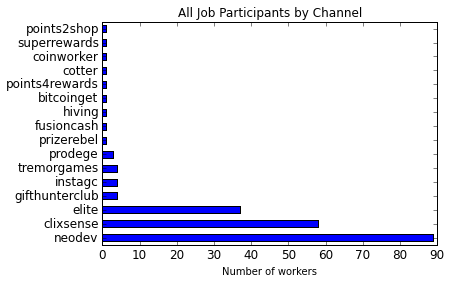

In [12]:
plot_by_group("channel", worker_profiles, "All Job Participants by Channel")

And here we see that the original distribution is also reflected in the people who managed to do some real work.

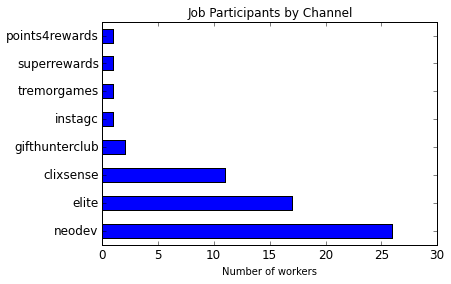

In [13]:
temp = worker_profiles.query("test_ques_accuracy >= 0.7 and work_units_seen > 0")
plot_by_group("channel", temp, "Job Participants by Channel")

### Worker speed by channel

How fast were the workers from each channel? Since this is a difficult job, involving lots of reading, we would expect that workers would take at least 20 seconds per work unit if they were actually doing the job properly.

In [14]:
def plot_work_speed(column, dataframe, title, figsize):
    """
    Plot speed of work.
    """
    graph = dataframe.boxplot("work_median_time_per_unit", by = column, figsize = figsize,
                     rot = 75, fontsize = 12)

    graph.set_ylabel("Median response time per work unit in seconds")
    graph.set_title(title)

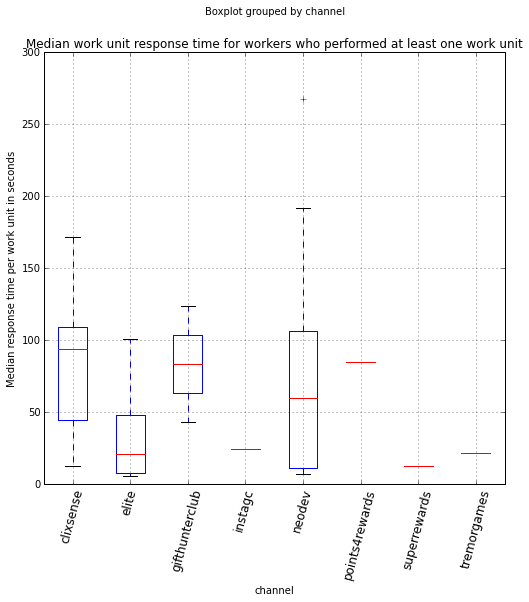

In [15]:
temp = worker_profiles.query("test_ques_accuracy >= 0.7 and work_units_seen > 0")
plot_work_speed("channel", temp,
                "Median work unit response time for workers who performed at least one work unit",
                (8, 8))

From above we can see that some channels, such as the "CrowdFlower elite" channel, seem to work much faster than the other channels.

### Find bad workers

Now that we have a profile about every worker who did the job, we can try to find the bad workers.

Signs that a worker may be bad:
1. Only chooses one answer choice for all work units.
2. Evenly distributes answer choices over all possible answers (within some threshold).

In [16]:
def find_bad_workers(raw_data, worker_profiles):
    def equal_distribution(distribution):
        equal_val = distribution.sum() / len(distribution)
        low = 0.95 * equal_val
        high = 1.05 * equal_val
        
        for val in distribution:
            if not (low <= val <= high):
                return False
            
        return True
    
    work_data = raw_data.query("~is_test_ques")
    passed_workers = set(worker_profiles.query("work_units_seen > 0")["worker_id"])

    bad_workers = set()
    for worker_id in passed_workers:
        work_resp = work_data.query("worker_id == '{0}'".format(worker_id))
        work_distribution = work_resp["worker_response"].value_counts()
        
        if len(work_distribution) == 1:
            bad_workers.add(worker_id)
        elif equal_distribution(work_distribution):
            bad_workers.add(worker_id)
            
    return bad_workers

In [17]:
bad_workers = find_bad_workers(raw_data, worker_profiles)

In [18]:
bad_workers

{'2490e2cd',
 '2d02017d',
 '2ee16933',
 '52afde60',
 '5ff70619',
 '646bd7d3',
 '6a66d737',
 '6c18bf95',
 '6d9317d3',
 '7ee53415',
 '8e116933',
 'bfe4d311',
 'c10a5e9c',
 'd35171ff'}

In [19]:
len(bad_workers)

14

Let's look at the statistics for each bad worker:

In [20]:
res = worker_profiles.query("worker_id in {0}".format(list(bad_workers)))

In [21]:
res

,channel,test_max_time_per_unit,test_median_time_per_unit,test_min_time_per_unit,test_ner_mistake,test_no_relation,test_ques_accuracy,test_ques_seen,test_yes_direct,test_yes_indirect,work_max_time_per_unit,work_median_time_per_unit,work_min_time_per_unit,work_ner_mistake,work_no_relation,work_units_seen,work_yes_direct,work_yes_indirect,worker_id
27,elite,19.666667,5.916667,5.166667,1,33,0.9565,46,11,1,14.333333,5.833333,5.166667,0,198,198,0,0,2490e2cd
33,neodev,13.333333,7.666667,7.000000,1,21,0.9355,31,9,0,9.666667,7.666667,7.000000,121,0,121,0,0,2d02017d
37,elite,67.333333,15.333333,10.166667,0,42,0.8654,52,10,0,67.333333,13.666667,10.166667,0,230,230,0,0,2ee16933
59,neodev,20.166667,8.666667,7.166667,2,34,0.9423,52,15,1,20.166667,8.333333,7.166667,230,0,230,0,0,52afde60
72,elite,31.000000,11.500000,5.833333,1,8,1.0000,10,1,0,31.000000,13.333333,5.833333,0,17,17,0,0,5ff70619
75,elite,100.833333,98.000000,98.000000,0,5,0.8571,7,2,0,100.833333,100.833333,100.833333,0,5,5,0,0,646bd7d3
78,neodev,45.833333,45.833333,6.000000,0,6,1.0000,8,2,0,12.333333,9.166667,6.000000,0,5,10,5,0,6a66d737
81,elite,40.166667,16.833333,11.333333,1,13,1.0000,18,3,1,40.166667,21.916667,11.333333,0,60,60,0,0,6c18bf95
82,elite,24.333333,6.250000,5.000000,1,36,0.9808,52,14,1,24.333333,6.000000,5.000000,0,230,230,0,0,6d9317d3
96,neodev,19.500000,15.000000,7.666667,0,8,1.0000,11,2,1,19.500000,8.333333,7.666667,25,0,25,0,0,7ee53415


Which channels did the bad workers come from?

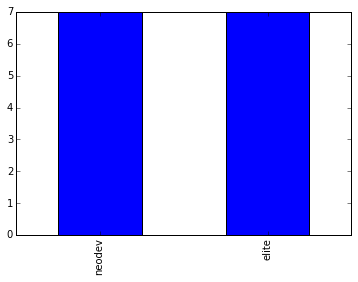

In [22]:
res["channel"].value_counts().plot(kind = "bar")

How fast were they working?

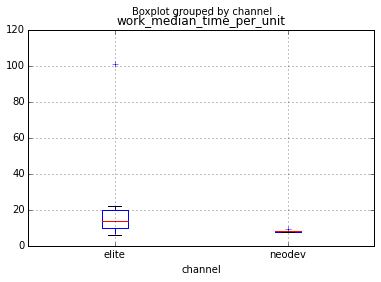

In [23]:
res.boxplot("work_median_time_per_unit", by = "channel")

The neodev channel cheaters seem to be working way too quickly. Their average rate is only 10 seconds per work unit! Combined with the fact that these workers were only choosing one answer for all of their responses ("ner_mistake"), it is very likely that these are computer programs responding as quickly as possible in order to maximize profit.

### Response over time:

Looking at the worker's response pattern as a function of time also gives us an idea of whether they are likely to be cheating.

In [24]:
def work_time_plot(worker_id, start = 0):
    data = raw_data.query("worker_id == '{0}'".format(worker_id))
    
    times = list(data["submit_time"].unique())
    times = map(convert_time, times)
    times = sorted(times)
    
    first = times[0]
    times = map(lambda x: time_elapsed(first, x), times)
    
    diff = [times[i+1] - times[i] for i in range(0, len(times) - 1)]
    diff = diff[start : ]

    title = "Time in seconds between worker {0}'s responses".format(worker_id)
    graph = pd.Series(diff).plot(fontsize = 12, title = title)
    graph.set_ylim((0, max(diff) * 1.1))
    
    graph.set_xlabel("Individual pages of work completed")
    graph.set_ylabel("Time in seconds between consecutive pages of work")    

If we look at a known good worker's response profile (given below), we see that the worker begins by taking a long time to work on each page of work, needing around 250 seconds (4 minutes) for six work units. Sometimes the questions are easier than others, and sometimes they are more difficult, resulting in a plot that decreases and increases randomly. Overall though the worker becomes more skilled and confident with time, and the overall time needed decreases steadily.

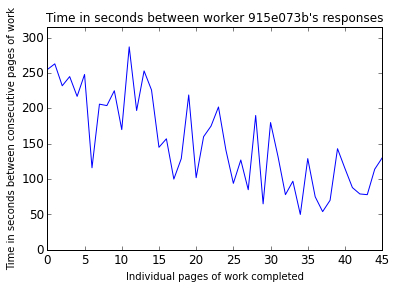

In [25]:
# a known good worker as determined manually
work_time_plot("915e073b")

However, if we look at the time response profiles for a bad worker, then we see a different story:

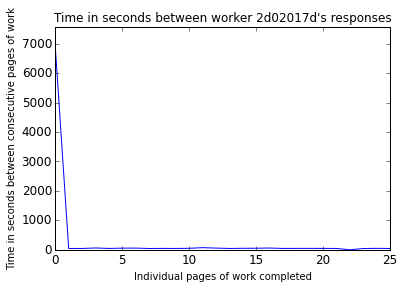

In [26]:
work_time_plot("2d02017d")

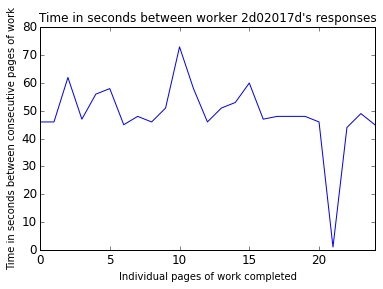

In [27]:
work_time_plot("2d02017d", 1)

This worker waited 7000 seconds (roughly two hours) between his first page of work and his second page of work. From his second unit of work onwards, he took roughly a constant amount amount of time for each page of work (~45 seconds), which is even faster than the fastest the good worker was by the end.

The large gap in time between the first and second pages of work, the fast rate of submission, the lack of variation in response time, and constant response distribution strongly suggest that worker 2d02017d was in fact a computer program designed to respond as quickly as possible in order to maximize profit.

---

## Conclusion

Using a combination of worker response distribution, response time, and response timings, we can deduce which workers are likely to be computer programs designed to maximize profit.

The take home lessons are:
1. Use worker response distributions to find workers who are likely to be cheating.
2. Monitor worker response speeds to find workers who are going much faster than expected.
3. Monitor worker response timings to look for oddities in when workers are submitting tasks.